In [ ]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATH / 'morse_dataset'
SAVE_DIR = MAIN / 'spectrogram'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 30
TIME_MASK = 40

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0002 #2e-4
WEIGHT_DECAY = 0.001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}
def preload(df, transforms, fodl_name):
    specs = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        file_id = row["id"]
        audio_path = DATASET_PATH / file_id

        try:
            waveform, sr = torchaudio.load(audio_path)
            mel_spec = transforms(waveform)
            torch.save(mel_spec, SAVE_DIR /fodl_name/ f"{file_id}.pt")

        except Exception as e:
            print(f"Ошибка в {file_id}: {e}")

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATH,'sample_submission.csv'))

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK), 
    transforms.TimeMasking(time_mask_param=TIME_MASK), 
    )

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.2, random_state=SEED)
train_dataframe


,id,message
21753,21754.opus,РГШ28Ф
251,252.opus,ЦЧАЩ3ДМ
22941,22942.opus,2 М #ЮНЭОП
618,619.opus,ТЪ5Ю6Ы0БХ
17090,17091.opus,ФТЗСК ЙЭФТ
...,...,...
29802,29803.opus,С ТЪ7Е#Л0
5390,5391.opus,СИРЙ 3Ю1ЯЫ
860,861.opus,Х#ЦБНЙМТРХИ
15795,15796.opus,ФЛЯ ОСОЩШ


In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=True, 
                                       collate_fn=my_collate, 
                                       drop_last=True,
                                       num_workers=2)
for i, batch in enumerate(train_dl):
    print(f"Batch {i} загружен")
    if i == 3: break

In [ ]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 30
TIME_MASK = 40

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0002 #2e-4
WEIGHT_DECAY = 0.001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)
            spec_lens = augmented_spectrogram.shape[-1]
            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, spec_lens, target ,target_len, message
            else:
                return augmented_spectrogram,spec_lens, None, None, None
        except Exception as ex:
            print(f"Ошибка при загрузке файла {audio_file}: {ex}")
            return ex
    
FIRST_FE_COUNT = 64
SECOND_FE_COUNT = 128
THIRD_FE_COUNT = 128
QAD_FE_COUNT = 128
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 512
# Start with 4 transforms
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # [B, C, 1, 1]
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction),  # [B, C/reduction]
            nn.GELU(),
            nn.Linear(channels // reduction, channels),  # [B, C]
            nn.Sigmoid()
        )
    
    def forward(self, x):
        B, C, _, _ = x.shape
        squeezed = self.squeeze(x).view(B, C)  # [B, C]
        weights = self.excitation(squeezed).view(B, C, 1, 1)  # [B, C, 1, 1]
        return x * weights # масштабирование
    

class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.Dropout2d(0.2),  # добавлено
            SEBlock(FIRST_FE_COUNT, 4),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.Dropout2d(0.2),  # добавлено
            nn.GELU(),
            SEBlock(SECOND_FE_COUNT, 8),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.Dropout2d(0.2),  # добавлено
            SEBlock(THIRD_FE_COUNT, 16),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT, 16),
            nn.Dropout2d(0.2),  # добавлено
            nn.GELU(),
            SEBlock(QAD_FE_COUNT),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 16, 89](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()

        print(f"Проекция из {self.cnn_output_features} в {GRU_HIDEN*2}")
        self.rnn = nn.LSTM(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=3,
                bidirectional=True,
                dropout=0.5,
                batch_first=True 
            )

        self.embed_dim = GRU_HIDEN * 2

        self.mha = nn.MultiheadAttention(self.embed_dim, 8, dropout=0.3, batch_first=True)

        self.layer_norm = nn.LayerNorm(self.embed_dim)  

        self.dropout = nn.Dropout(0.5)   

        self.layer2 = nn.Linear(self.embed_dim, num_classes)     

    def _get_output_lengths(self, input_lengths):
        output_lengths = torch.floor(input_lengths.float() / 4); 
        return torch.clamp(output_lengths.long(), min=1).to(DIVICE)
    
    def forward(self, x, input_lengths):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)
        
        output_lengths = self._get_output_lengths(input_lengths)
        output_lengths.to(DIVICE)
        self.rnn.flatten_parameters()
        # x = self.layer_norm1(x)
        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний

        #att
        max_len = reduced_time; 
        idx = torch.arange(max_len, device=DIVICE).unsqueeze(0); 
        key_padding_mask = (idx >= output_lengths.unsqueeze(1))
        attenc, _ = self.mha(x, x, x, key_padding_mask=key_padding_mask)
        x = x + self.dropout(attenc)
        x = self.layer_norm(x)
        # x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        '''
        return x
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK), 
    transforms.TimeMasking(time_mask_param=TIME_MASK), 
    )

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.25, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)


def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)
    # spec_lens = torch.stack([item[0] for item in batch])
    spec_lens = torch.tensor([item[1] for item in batch]).reshape(BATCH_SIZE)
    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[2] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[3] for item in batch])
        msg = [item[4] for item in batch]
        
        return [spectrograms_padded, spec_lens, target, label_len, msg]
    else: 
        return [spectrograms_padded, spec_lens]

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=True, 
                                       collate_fn=my_collate, 
                                       drop_last=True,
                                       num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     collate_fn=my_collate, 
                                     drop_last=True,
                                     num_workers=4, pin_memory=True)

test, test_lens, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_lens, val_target, __, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DIVICE)
# model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)  # Было 0.002
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

In [2]:
test_lens

tensor([356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356,
        356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356,
        356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356,
        356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356,
        356, 356, 356, 356, 356, 356, 356, 356])

In [3]:
a = model(test, test_lens)
a.shape

torch.Size([89, 64, 45])

# Обучение модели

In [2]:
import Levenshtein
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds


In [2]:
lst_loss_train = []
lst_loss_val = []
best_val_loss = 0
for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    train_predicts = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, mel_spec_lens, targets, targets_lens, _ = batch
        mel_spec = mel_spec.to(DIVICE)
        mel_spec_lens = mel_spec_lens.to(DIVICE)
        targets = targets.to(DIVICE)
        targets_lens = targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec, mel_spec_lens) # (N=batch,T,C)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue

        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    total_train = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    total_val = 0
    val_predicts = []

    with torch.no_grad():
        val_tqdm = tqdm(val_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", leave=False)
        for val_mel_spec, val_spec_lens, val_labels, val_label_lensin, _ in val_tqdm:

            val_mel_spec = val_mel_spec.to(DIVICE)
            val_spec_lens = val_spec_lens.to(DIVICE)
            val_labels = val_labels.to(DIVICE)
            val_label_lensin = val_label_lensin.to(DIVICE)

            val_predict = model(val_mel_spec, val_spec_lens)
            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]

            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

    total_val = val_loss / len(val_dl)

    lst_loss_train.append(total_train)
    lst_loss_val.append(total_val)

    scheduler.step(total_val)

    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")\
    #===== Инфо про градиенты=====
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")
    #===== Инфо про шаг обучения и данные по потерям =====
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    print(f"---- Train Loss: {total_train:.4f}")
    print(f"---- Val Loss: {total_val:.4f}")
    if current_lr <= 1e-6:
        print("Learning rate достиг минимума 1e-6, остановка обучения")
        break
    print("-" * 50)

KeyboardInterrupt: 

In [4]:
torch.save(model.state_dict(), 'MorseNet.pth')

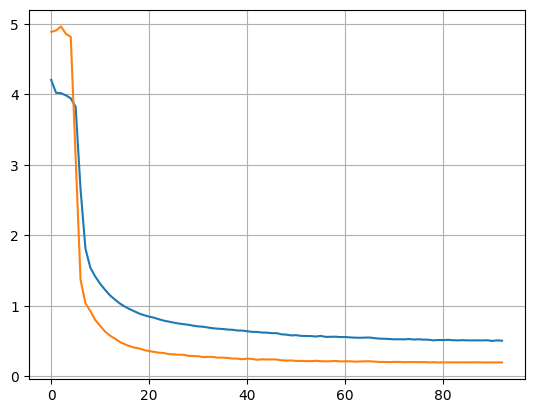

In [5]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [6]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes).to(DIVICE)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq,seq_lens, test_target, _, mess = loader
        seq = seq.to(DIVICE)
        seq_lens = seq_lens.to(DIVICE)
        train_mess.extend(mess)

        logits = model_load(seq,seq_lens)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq,seq_lens, test_target, _, mess = loader
        seq = seq.to(DIVICE)
        seq_lens = seq_lens.to(DIVICE)
        val_mess.extend(mess)

        logits= model_load(seq,seq_lens)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

CNN размерность выхода: torch.Size([1, 16, 16, 89])
CNN число фичей: 256
Проекция из 256 в 512
Mean accurasu by The Levenshtein in train is : 0.8673547668538801
Mean accurasu by The Levenshtein in validate is : 0.9347409836731654


# Сбор sample_submission

In [ ]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes).to(DIVICE)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)

def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)
    # spec_lens = torch.stack([item[0] for item in batch])
    spec_lens = torch.tensor([item[1] for item in batch]).reshape(BATCH_SIZE*2)
    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[2] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[3] for item in batch])
        msg = [item[4] for item in batch]
        
        return [spectrograms_padded, spec_lens, target, label_len, msg]
    else: 
        return [spectrograms_padded, spec_lens]
    
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=my_collate)
model_load.eval()
next(iter(test_dl))
with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq, seq_lens = loader
        seq = seq.to(DIVICE)
        seq_lens = seq_lens.to(DIVICE)

        logits = model_load(seq,seq_lens)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 16, 16, 89])
CNN число фичей: 256
Проекция из 256 в 512


RuntimeError: shape '[128]' is invalid for input of size 8